<a href="https://colab.research.google.com/github/duc-ke/kaggle-playground-group/blob/main/7.CT_lung_segmentation/st1_1_train(keras_simpleUnet)_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Very simple U-Net training (Keras ver.)
[Colab GPU 환경 셋팅(필수)]
* [런타임] - [런타임유형변경] - [가속기] - GPU 선택 후 저장

In [1]:
!git clone https://github.com/duc-ke/kaggle-playground-group.git

Cloning into 'kaggle-playground-group'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (427/427), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 427 (delta 203), reused 263 (delta 85), pack-reused 0
Receiving objects: 100% (427/427), 175.53 MiB | 17.77 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Checking out files: 100% (77/77), done.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

# Load Dataset

In [3]:
x_train = np.load('kaggle-playground-group/7.CT_lung_segmentation/dataset/x_train.npy')
y_train = np.load('kaggle-playground-group/7.CT_lung_segmentation/dataset/y_train.npy')
x_val = np.load('kaggle-playground-group/7.CT_lung_segmentation/dataset/x_val.npy')
y_val = np.load('kaggle-playground-group/7.CT_lung_segmentation/dataset/y_val.npy')

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


# Build Model

In [4]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

# Train
* ReduceLROnPlateau 콜백 함수
  * factor : lr을 얼마나 감소 시킬지(new_lr = factor * lr)
  * mode : monitor가 최소/최대 중 무엇인지 알려주는 인자. min/max/auto
  * min_lr : lr의 하한선
  * 출처: https://deep-deep-deep.tistory.com/56

In [5]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])

Epoch 1/100
8/8 [==============================] - 25s 1s/step - loss: 0.5483 - acc: 0.7451 - mse: 0.1773 - val_loss: 0.4893 - val_acc: 0.7425 - val_mse: 0.1592 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 4s 486ms/step - loss: 0.4690 - acc: 0.7451 - mse: 0.1537 - val_loss: 0.4382 - val_acc: 0.7425 - val_mse: 0.1428 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 4s 485ms/step - loss: 0.4341 - acc: 0.7454 - mse: 0.1433 - val_loss: 0.4049 - val_acc: 0.7551 - val_mse: 0.1338 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 4s 483ms/step - loss: 0.3902 - acc: 0.7659 - mse: 0.1284 - val_loss: 0.3493 - val_acc: 0.7968 - val_mse: 0.1129 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 4s 483ms/step - loss: 0.3179 - acc: 0.8185 - mse: 0.1017 - val_loss: 0.2682 - val_acc: 0.8436 - val_mse: 0.0839 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 4s 483ms/step - loss: 0.3072 - acc: 0.8265 - mse: 0.0980 - val_loss: 0.

# Model Save

In [8]:
# model dir 생성 함수
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
 

In [9]:
# dir 생성 및 model 저장하기
dir_path = 'kaggle-playground-group/7.CT_lung_segmentation/models'
model_f = os.path.join(dir_path, 'lung_ct_keras.h5')

createFolder(dir_path)
model.save(model_f)

# Evaluation

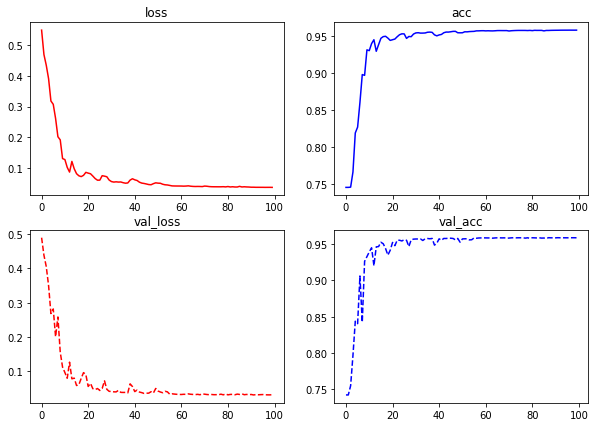

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

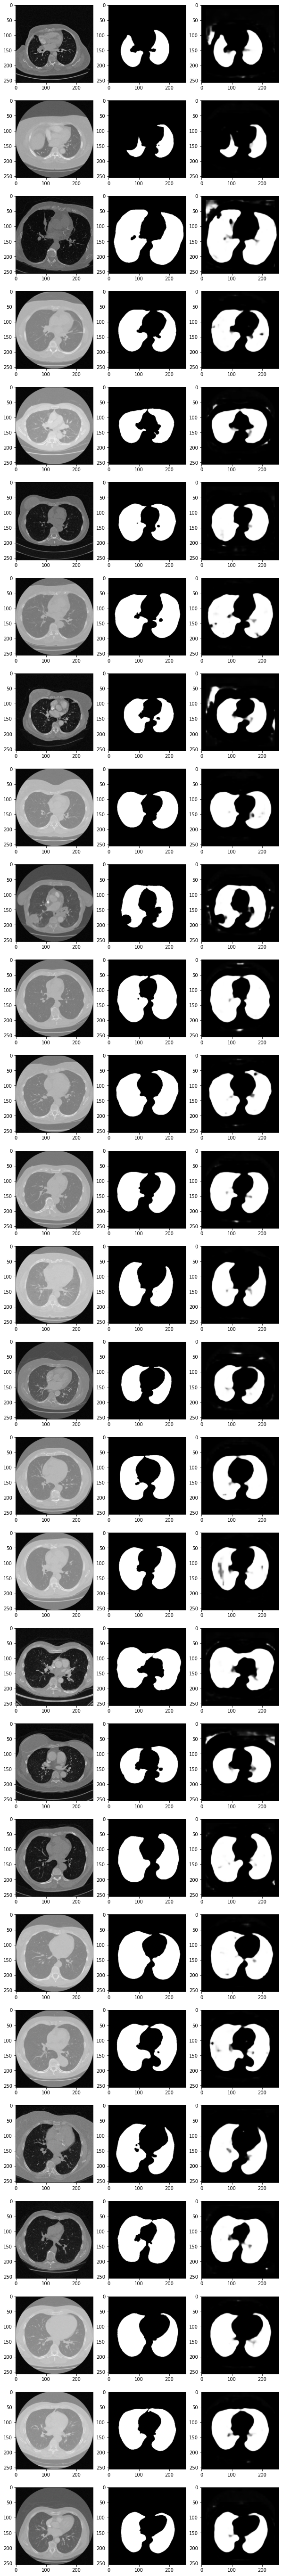

In [7]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')